# Notebook 2

- If you work on Google Colab, [![open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/jouvetg/glamod/blob/main/02_notebook/glacier-modelling-2.ipynb) and you will donwload the repo  below. Make sure to activate the GPU on Colab "Runtime" -> "Change Runtime Type" -> Slect GPU.

- If you work locally on your own PC, you can download the repo
```bash
git clone --depth 1 https://github.com/jouvetg/glamod.git
```
and then go the notebook folder, and work from there.

## Goals of this notebook

   - Get familiar with model IGM
   - Understand the parameters, set-up your model
   - Run IGM examples
   - Customization, run IGM for your own glacier

## What is IGM?

Here we will use the glacier evolution model developed at UNIL -- the Instructed Glacier Model.

The IGM is an open-source Python package, which permits to simulate 3D glacier evolution accounting for the coupling between ice thermo-dynamics, surface mass balance, and mass conservation. IGM is especially computationally efficient thanks to the TensorFlow library, mathematical operations are fully-vectorized. This permits important speed-ups on [GPU](https://en.wikipedia.org/wiki/Graphics_processing_unit) (Graphics Processing Units), which are devices made of many processors, and can therefore perform highly-parallelized computations.

All the documentation can be found at [https://igm-model.org/](https://igm-model.org/).

## How to install IGM?

Running IGM consists of running a python script `igm_run`, which is made of functions of the `igm` python package.  First of all, one needs to install igm as follows: (this may take a while, and it may crashes the first time, but should work the second time).

In [1]:
! pip install -i https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple igm-model-testing-package==3.0.5
! pip install ml-dtypes==0.5.3

Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple
  Using cached ml_dtypes-0.4.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached ml_dtypes-0.4.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml_dtypes 0.5.3
    Uninstalling ml_dtypes-0.5.3:
      Successfully uninstalled ml_dtypes-0.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.17.1 which is incompatible.
jax 0.7.2 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.4.1 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
tensorstore 0.1.78 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.4.1 which is incompatible.
ten

In this notebook, we will explore 3 model runs with increasing complexity:

- A first basic run with a simple surface mass balance model
- A second one that works for any glacier, with a more elaborate SMB
- A third with a user-defined SMB and particle tracking

## Download the data

Let's now download the repo with the data if you are using Colab

In [2]:
import sys, os

if "google.colab" in sys.modules:
    print("Running in Colab: cloning repo...")
    !git clone --depth 1 https://github.com/jouvetg/glamod.git
    !apt-get install tree -q
else:
    print("Running locally: using local files.")

Running in Colab: cloning repo...
fatal: destination path 'glamod' already exists and is not an empty directory.
Reading package lists...
Building dependency tree...
Reading state information...
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


Let's now go the working folder

In [3]:
if "google.colab" in sys.modules:
    %cd /content/glamod/02_notebook

/content/glamod/02_notebook


IGM is organized **module-wise** as shown in the following flowchart:

![](https://igm-model.org/latest/modules/flowchat-module.png)

As a user, you need to pick an ensemble of modules from existing ones (or you may create some user ones), and then define the parameters that deviate from default ones.

### Exploring the data (`input.nc`)

Before running IGM, it's useful to explore the input data file. The `input.nc` file is a NetCDF file that contains all the necessary spatial data for the glacier simulation, such as the bed topography, initial ice thickness, and other geographic information.

We can use the `xarray` library to easily load and explore NetCDF files. Let's look at what's inside the `input.nc` file:

## Second run with IGM

The above example is somewhat limited. In a second run, we are making improvements using `params_1.yaml` instead of `params_0.yaml`:

**First improvement:** Instead of using local data, we use the module `oggm_shop` to download all necessary data. The main advantage is that we can order any glacier using their RGI ID, and therefore get the data for any glacier on Earth!

**Second improvement:** OGGM will download climate data (a time series), which will serve to generate a climate (temperature and precipitation in module `clim_oggm`) to compute a better Surface Mass Balance model. Note this parameter in the parameter file:

```yaml
  clim_oggm:
    clim_trend_array:
      - ["time", "delta_temp", "prec_scal"]
      - [ 1900,           0.0,         1.0]
      - [ 2020,           0.0,         1.0]
      - [ 2100,           4.0,         1.0]
```

Similar to the previous method, this array assigns weights to modify precipitation and temperature series based on a *neutral* climate period, typically defined as 1960-1990. By adjusting the temperature offset in the `delta_temp` column, for example, a value of -2.0 would create a climate scenario for the 1960-1990 period that is 2 degrees cooler. Likewise, by modifying the precipitation scaling in the `prec_scal` column, a value of 1.5 would result in a climate scenario that has 150% of the precipitation compared to the 1960-1990 average.

Finally, you can incorporate this parameter to provide global control for melt (note that the melt parameters in the PDD model are notoriously uncertain):

```yaml
   melt_enhancer: 0.7
```

Find more information about the generated climate [here](https://igm-model.org/latest/modules/processes/clim_oggm/).

**Third improvement:** Instead of using the Simple Surface Mass Balance `smb_simple`, and now that we have climate available, we will use the `smb_oggm` SMB, which is a monthly temperature index model as described [here](https://igm-model.org/latest/modules/processes/smb_oggm/).

First explore `params_1.yaml`, then run the following command, which will model the Glacier with RGI ID `RGI60-11.01450` (the Great Aletsch Glacier, Switzerland) from 2020 to 2100, assuming a temperature increase of 4 degrees by 2100 relative to 1960–1990:

In [4]:
! igm_run +experiment=params_1

2025-11-05 07:45:33.460393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-05 07:45:33.479247: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-05 07:45:33.484993: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-05 07:45:33.499056: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-05 07:45:36.172864: W tensorflow/comp

Running the code has created the following output files:

Found 1 output file(s): ['outputs/2025-11-05/07-45-39/output.nc']


/content/glamod/02_notebook/helper.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.96])


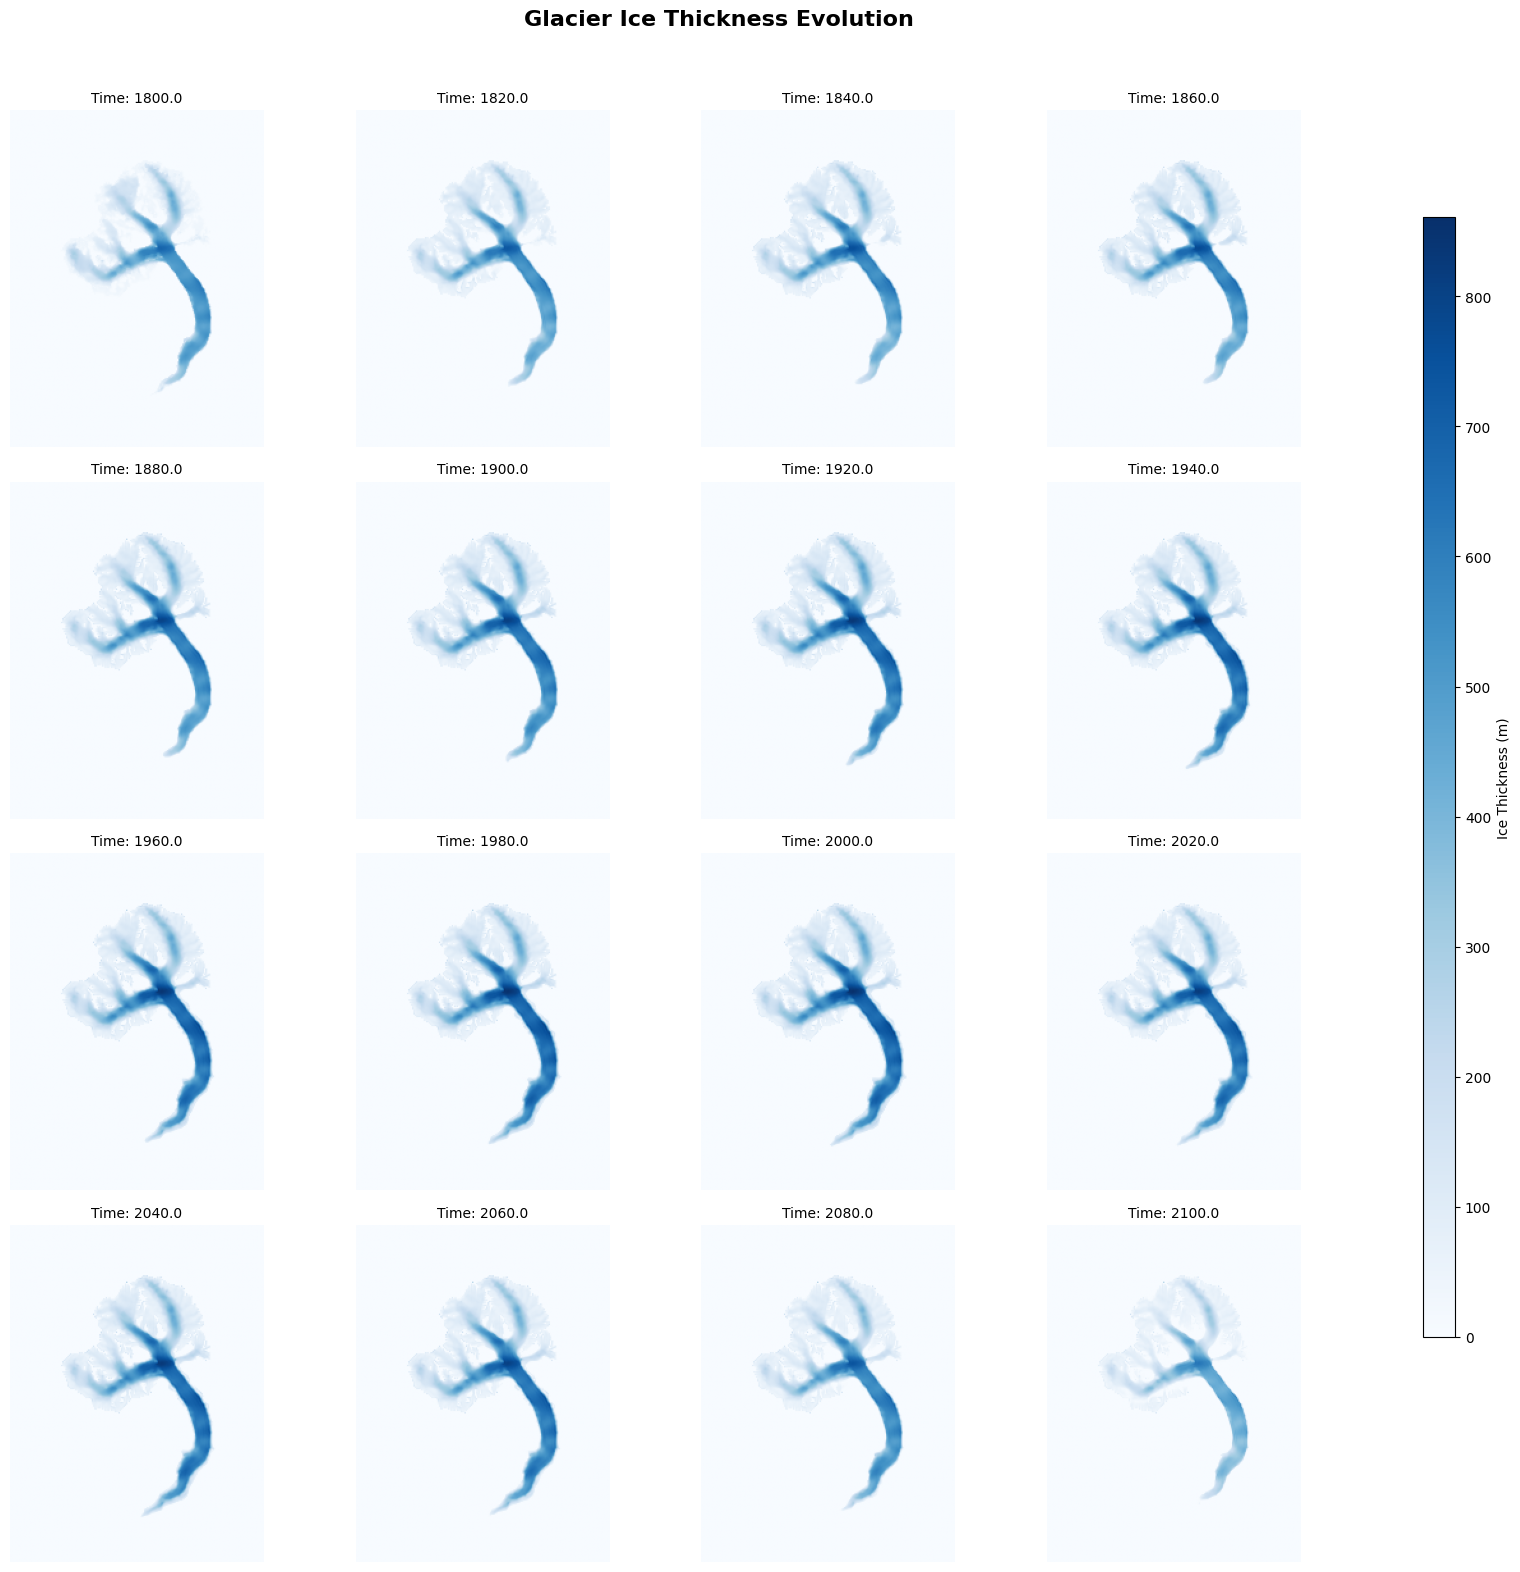

In [5]:
from helper import *
import glob

# Find all output files
A = glob.glob('outputs/*/*/output.nc')
print(f"Found {len(A)} output file(s):", A)

if A:
    # Animate the last run
    animate_glacier_evolution(A[-1])
else:
    print("No output.nc files found. Please run the model first.")

## Visualizing Climate Data

Let's explore the historical climate data that was used for the glacier simulation. We will open the `climate_historical.nc` file and plot the smoothed precipitation and temperature time series on the same graph.

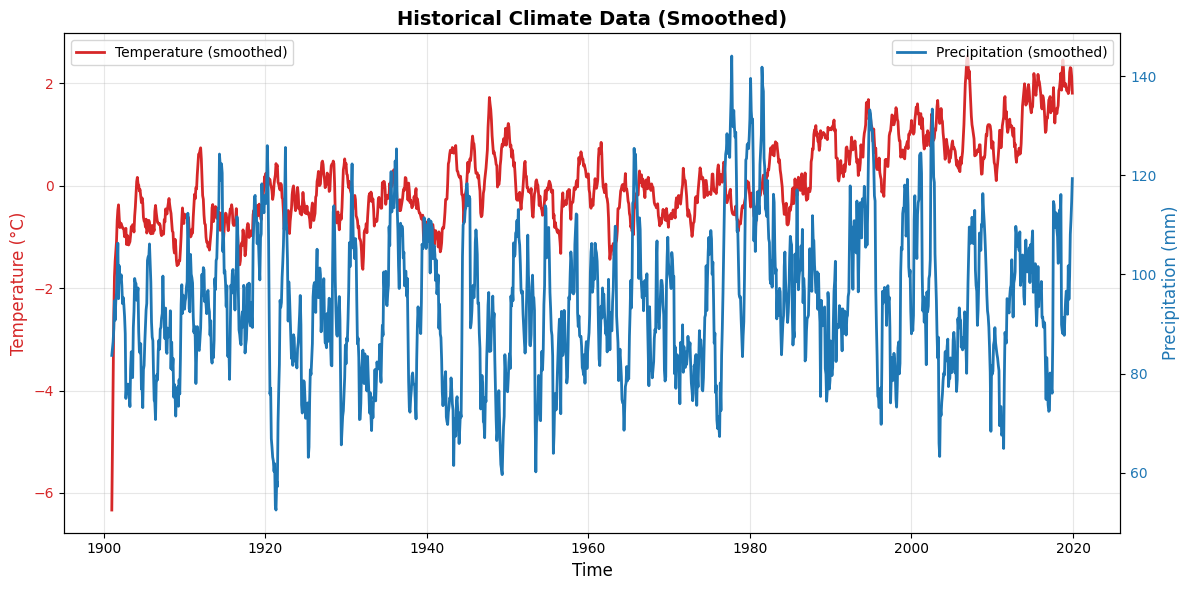


Climate Data Summary:
Time period: 1901-01-01T00:00:00.000000000 to 2019-12-01T00:00:00.000000000
Temperature range: -13.78°C to 12.20°C
Mean temperature: 0.09°C
Precipitation range: 0.00 to 395.17 mm
Mean precipitation: 93.71 mm


In [6]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d

# Open the climate data
climate_data = xr.open_dataset('data/RGI2000-v7.0-G-11-02596/climate_historical.nc')

# Extract temperature and precipitation
temp = climate_data['temp'].values
prcp = climate_data['prcp'].values
time = climate_data['time'].values

# Apply smoothing (moving average with window size of 12 months for annual smoothing)
window_size = 12
temp_smoothed = uniform_filter1d(temp, size=window_size, mode='nearest')
prcp_smoothed = uniform_filter1d(prcp, size=window_size, mode='nearest')

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot temperature on the left y-axis
color = 'tab:red'
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Temperature (°C)', color=color, fontsize=12)
ax1.plot(time, temp_smoothed, color=color, linewidth=2, label='Temperature (smoothed)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Create second y-axis for precipitation
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Precipitation (mm)', color=color, fontsize=12)
ax2.plot(time, prcp_smoothed, color=color, linewidth=2, label='Precipitation (smoothed)')
ax2.tick_params(axis='y', labelcolor=color)

# Add title and layout
plt.title('Historical Climate Data (Smoothed)', fontsize=14, fontweight='bold')
fig.tight_layout()

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

# Display some basic statistics
print(f"\nClimate Data Summary:")
print(f"Time period: {time[0]} to {time[-1]}")
print(f"Temperature range: {temp.min():.2f}°C to {temp.max():.2f}°C")
print(f"Mean temperature: {temp.mean():.2f}°C")
print(f"Precipitation range: {prcp.min():.2f} to {prcp.max():.2f} mm")
print(f"Mean precipitation: {prcp.mean():.2f} mm")

### Analyzing the time series results

Let's examine how the glacier evolved under the climate scenario:

Found 1 time series file(s). Using: outputs/2025-11-05/07-45-39/output_ts.nc

Reading time series data from: /content/glamod/02_notebook/outputs/2025-11-05/07-45-39/output_ts.nc



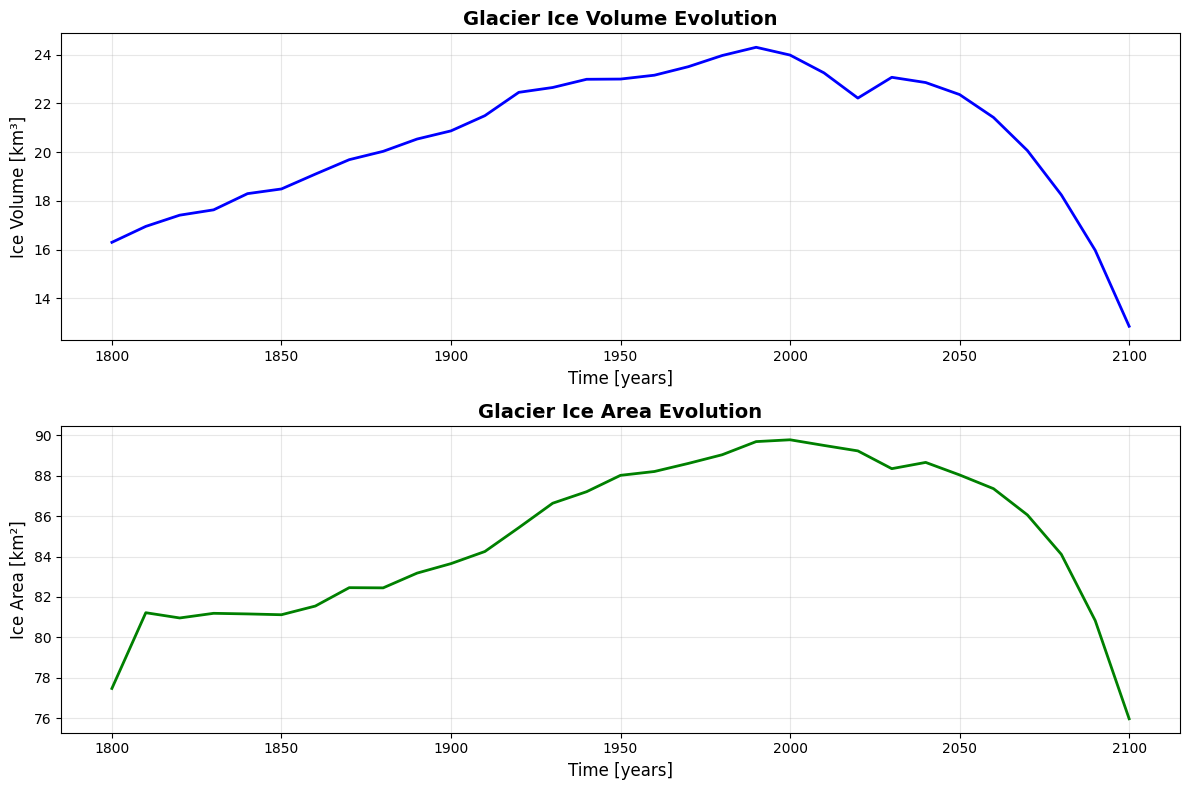


SUMMARY STATISTICS

Ice Volume:
  Initial: 16.30 km³
  Final:   12.86 km³
  Change:  -3.44 km³

Ice Area:
  Initial: 77.47 km²
  Final:   75.97 km²
  Change:  -1.50 km²


In [7]:
from helper import *
import glob
import os

# Find all time series files and select the most recent one
ts_files = sorted(glob.glob('outputs/*/*/output_ts.nc'))

if ts_files:
    # Get the absolute path to ensure it works from any directory
    ts_file = os.path.abspath(ts_files[-1])
    print(f"Found {len(ts_files)} time series file(s). Using: {ts_files[-1]}\n")
    # Analyze the time series from the most recent run
    analyze_time_series(ts_file)
else:
    print("No output_ts.nc file found. Please run the model first.")